<a href="https://colab.research.google.com/github/cristopher-d-delgado/image_classification_pneumonia/blob/main/mlp_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pneumonia Detection on Chest X-Rays

In [1]:
# Import data managing libraries
import numpy as np
import pandas as pd

# Import Tensorflow
import tensorflow as tf
import tensorflow.keras as keras

# Plotting
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import random
# Set the seed for repeatability
seed = 42

# Set random seed for NumPy
np.random.seed(42)

# Set random seed for TensorFlow
tf.random.set_seed(42)

# Set random seed for Python's built-in random module
random.seed(42)

In [2]:
# # Google Drive connection

# from google.colab import drive
# drive.mount('/content/drive/')

Mounted at /content/drive/


# Explore our Data & Preprocess

In [2]:
import os
# Create a path to the root folder and path to specific folders on my computer
# data_path = '/content/drive/MyDrive/Flatiron/phase4/chest_xray/chest_xray'
data_path = 'data\chest_xray\chest_xray'
data_path

# Specificy paths for train, test, val
train_folder = os.path.join(data_path, 'train')
test_folder = os.path.join(data_path, 'test')
val_folder = os.path.join(data_path, 'val')

# Specify paths for labels
train_normal = os.path.join(train_folder, 'NORMAL')
train_pneumonia = os.path.join(train_folder, 'PNEUMONIA')
test_normal = os.path.join(test_folder, "NORMAL")
test_pneumonia = os.path.join(test_folder, "PNEUMONIA")
val_normal = os.path.join(val_folder, "NORMAL")
val_pneumonia = os.path.join(val_folder, "PNEUMONIA")

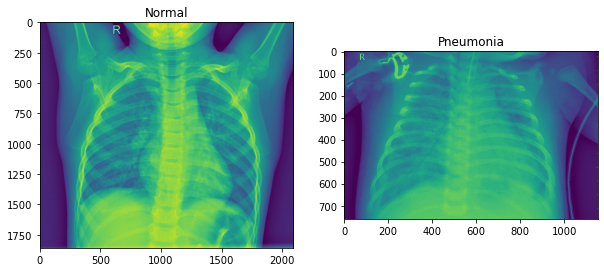

In [4]:
from PIL import Image
import matplotlib.pyplot as plt

# Read images
# img1 = Image.open("/content/drive/MyDrive/Flatiron/phase4/chest_xray/train/NORMAL/IM-0115-0001.jpeg")
# img2 = Image.open("/content/drive/MyDrive/Flatiron/phase4/chest_xray/train/PNEUMONIA/person1000_bacteria_2931.jpeg")
img1 = Image.open("data/chest_xray/chest_xray/train/NORMAL/IM-0115-0001.jpeg")
img2 = Image.open("data/chest_xray/chest_xray/train/PNEUMONIA/person1000_bacteria_2931.jpeg")
# Display images side by side
plt.figure(figsize=(10, 5))

# Plot the first image
plt.subplot(1, 2, 1)
plt.imshow(img1)
plt.title('Normal')

# Plot the second image
plt.subplot(1, 2, 2)
plt.imshow(img2)
plt.title('Pneumonia')

plt.show()

It seems that the images are not actually on the same size. Visually we can see the bacterial infection. We would have to preprocess the images to become the same size and also lower the scale since training a neuwral network is resource intensive. Lets explore how many images we have in each directory.

In [5]:
print('There are', len(os.listdir(train_normal)), 'normal images in the training set')
print('There are', len(os.listdir(train_pneumonia)), 'pneumonia images in the training set')
print("________________________________________________________________________________________")
print('There are', len(os.listdir(test_normal)), 'normal images in the testing set')
print('There are', len(os.listdir(test_pneumonia)), 'pneumonia images in the testing set')
print("________________________________________________________________________________________")
print('There are', len(os.listdir(val_normal)), 'normal images in the validation set')
print('There are', len(os.listdir(val_pneumonia)), 'pneumonia images in the validation set')

There are 1342 normal images in the training set
There are 3876 pneumonia images in the training set
________________________________________________________________________________________
There are 234 normal images in the testing set
There are 390 pneumonia images in the testing set
________________________________________________________________________________________
There are 9 normal images in the validation set
There are 9 pneumonia images in the validation set


Lets preprocess the images by resizing to (128, 128, 3)

In [6]:
# Preprocess our Data
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set the path for data folders
train_data_dir = train_folder
test_data_dir = test_folder
val_data_dir = val_folder

# Set the input size for images
img_size = (128, 128)

# Set up data generators for training, testing, and validation
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=img_size,
    batch_size=64,
    class_mode='binary'  # Use 'categorical' if you have more than two classes
)

test_generator = datagen.flow_from_directory(
    test_data_dir,
    target_size=img_size,
    batch_size=64,
    class_mode='binary'
)

val_generator = datagen.flow_from_directory(
    val_data_dir,
    target_size=img_size,
    batch_size=4,
    class_mode='binary'
)

# Optionally, check the class indices assigned by Keras
print("Class indices:", train_generator.class_indices)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Class indices: {'NORMAL': 0, 'PNEUMONIA': 1}


Image dimensions: (128, 128, 3)


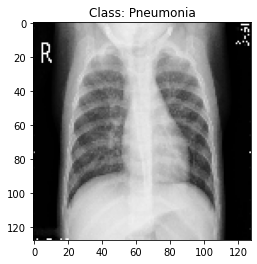

In [7]:
# Retrieve one batch of images from the generator
images, labels = train_generator.next()

# Print the dimensions of the first image
print("Image dimensions:", images[0].shape)

# Display the first image
plt.imshow(images[0])
plt.title(f"Class: {'Normal' if labels[0] == 0 else 'Pneumonia'}")
plt.show()

We sucecssfully resized the images and also created an RGB tensor. Lets create our datasets

In [32]:
# Create the data sets with resized images
def generate_data_sets(train_generator, test_generator, val_generator):

    # Define batches from generators
    train_batches = train_generator
    test_batches = test_generator
    val_batches = val_generator

    # Create Train Set
    X_train, y_train = [], []
    for batch in train_batches:
        # get the images from train gen
        X_train.append(batch[0])
        # get the labels from train gen
        y_train.append(batch[1])

    # Concatenate batches along the first axis
    X_train = np.concatenate(X_train)
    y_train = np.concatenate(y_train)

    # Create the test set
    X_test, y_test = [], []
    for batch in test_batches:
        # get the images from test gen
        X_test.append(batch[0])
        # get the labels from test gen
        y_test.append(batch[1])

    # Concatenate batches along the first axis
    X_test = np.concatenate(X_test)
    y_test = np.concatenate(y_test)

    # Create the val set
    X_val, y_val = [], []
    for batch in val_batches:
        # get the images from val gen
        X_val.append(batch[0])
        # get the labels from val gen
        y_val.append(batch[1])

    # Concatenate batches along the first axis
    X_val = np.concatenate(X_val)
    y_val = np.concatenate(y_val)

    return X_train, X_test, X_val, y_train, y_test, y_val


In [33]:
# # Generate data sets
# X_train, X_test, X_val, y_train, y_test, y_val = generate_data_sets(train_generator, test_generator, val_generator)

# # Print the shapes of the obtained sets
# print("X_train shape:", X_train.shape)
# print("y_train shape:", y_train.shape)
# print("X_test shape:", X_test.shape)
# print("y_test shape:", y_test.shape)
# print("X_val shape:", X_val.shape)
# print("y_val shape:", y_val.shape)

In [8]:
# create the temporary data sets to view shapes
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

# Explore dataset
m_train = train_images.shape[0]
num_px = train_images.shape[1]
m_test = test_images.shape[0]
m_val = val_images.shape[0]

print ("Number of training samples: " + str(m_train))
print ("Number of testing samples: " + str(m_test))
print ("Number of validation samples: " + str(m_val))
print ("train_images shape: " + str(train_images.shape))
print ("train_labels shape: " + str(train_labels.shape))
print ("test_images shape: " + str(test_images.shape))
print ("test_labels shape: " + str(test_labels.shape))
print ("val_images shape: " + str(val_images.shape))
print ("val_labels shape: " + str(val_labels.shape))

Number of training samples: 64
Number of testing samples: 64
Number of validation samples: 4
train_images shape: (64, 128, 128, 3)
train_labels shape: (64,)
test_images shape: (64, 128, 128, 3)
test_labels shape: (64,)
val_images shape: (4, 128, 128, 3)
val_labels shape: (4,)


# Make an Multilayer Perceptrons Model

I don't expect great perfomance in comparison to a Convuluted Neural Network. For the sake of trying we should attempt a basic neural network before getting more complex using basic MLP layers

**Base MLP Model:**

Define Base Model

We can attempt to train the model by iterating over the numebr of epochs. We can then save look at the validation and training loss and see where it begins to overfit.

In [35]:
# import time
# import pandas as pd
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Flatten, Dense
# from tensorflow.keras.optimizers import Adam

# # Initialize an empty DataFrame to hold epoch information
# epoch_data_df = pd.DataFrame(columns=['Epoch', 'Train Loss', 'Validation Loss', 'Train Accuracy', 'Validation Accuracy'])

# # Define the model outside the loop
# model_mlp_base = Sequential()
# model_mlp_base.add(Flatten(input_shape=(128, 128, 3)))
# model_mlp_base.add(Dense(60, activation='relu'))
# model_mlp_base.add(Dense(1, activation='sigmoid'))
# model_mlp_base.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
# print(model_mlp_base.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_8 (Flatten)         (None, 49152)             0         
                                                                 
 dense_12 (Dense)            (None, 60)                2949180   
                                                                 
 dense_13 (Dense)            (None, 1)                 61        
                                                                 
Total params: 2949241 (11.25 MB)
Trainable params: 2949241 (11.25 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [14]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import time

def train_model_and_get_epoch_data(model, train_generator, val_generator, total_epochs, save_history_path):
    # Initialize callbacks
    callbacks = [
        EarlyStopping(monitor='loss', patience=3),
        ReduceLROnPlateau(monitor='loss', patience=3),
        ModelCheckpoint('model_best.keras', monitor='loss', save_best_only=True) # save the best model
    ]

    # Record the start time for training all epoch range
    start_time = time.time()

    # Train the model for set epochs
    history = model.fit(train_generator, epochs=total_epochs, validation_data=val_generator, callbacks=callbacks)

    # Save the history dictionary to a .npy file
    np.save(save_history_path, history.history)

    # Record the end time for the current epoch
    end_time = time.time()

    # Print the total training time
    total_training_time = end_time - start_time
    print(f"Total training time: {total_training_time} seconds")

    # Return the history
    return history

In [42]:
# base_data = train_model_and_get_epoch_data(model_mlp_base, train_generator, val_generator, total_epochs=40, save_history_path="base_history.npy")
# print(base_data)

Epoch 1/40
82/82 [==============================] - 42s 513ms/step - loss: 0.1064 - accuracy: 0.9734 - val_loss: 0.3061 - val_accuracy: 0.9375 - lr: 1.0000e-05
Epoch 2/40


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


82/82 [==============================] - 43s 526ms/step - loss: 0.1064 - accuracy: 0.9732 - val_loss: 0.3091 - val_accuracy: 0.9375 - lr: 1.0000e-05
Epoch 3/40
82/82 [==============================] - 42s 512ms/step - loss: 0.1064 - accuracy: 0.9732 - val_loss: 0.3197 - val_accuracy: 0.9375 - lr: 1.0000e-05
Epoch 4/40
82/82 [==============================] - 42s 518ms/step - loss: 0.1063 - accuracy: 0.9735 - val_loss: 0.3122 - val_accuracy: 0.9375 - lr: 1.0000e-05
Epoch 5/40
82/82 [==============================] - 42s 509ms/step - loss: 0.1064 - accuracy: 0.9732 - val_loss: 0.3288 - val_accuracy: 0.8750 - lr: 1.0000e-05
Epoch 6/40
82/82 [==============================] - 42s 514ms/step - loss: 0.1064 - accuracy: 0.9726 - val_loss: 0.3014 - val_accuracy: 0.9375 - lr: 1.0000e-05
Epoch 7/40
82/82 [==============================] - 42s 517ms/step - loss: 0.1063 - accuracy: 0.9730 - val_loss: 0.3131 - val_accuracy: 0.9375 - lr: 1.0000e-05
Epoch 8/40
82/82 [==============================] -

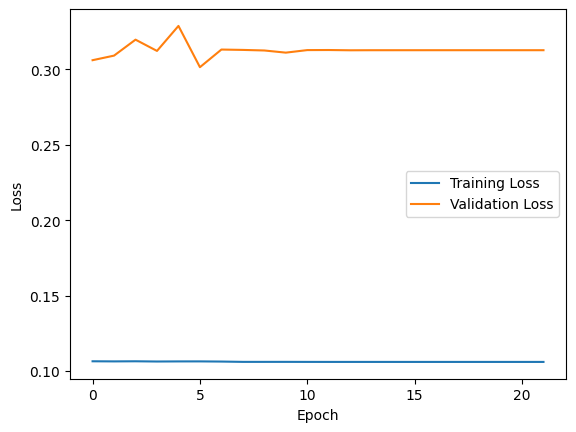

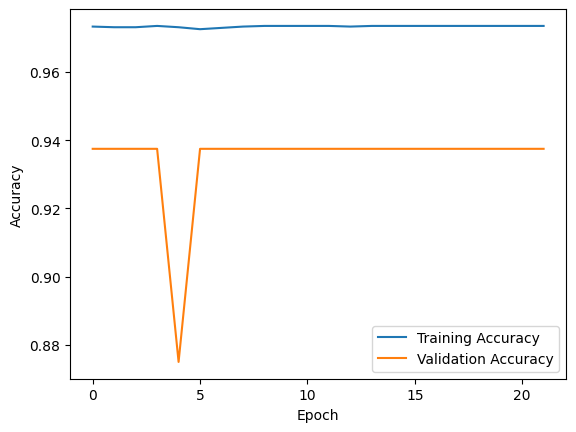

In [44]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load the training history
loaded_history = np.load('/content/drive/MyDrive/Flatiron/phase4/base_history.npy', allow_pickle=True).item()

# Plot the training loss and validation loss
plt.plot(loaded_history['loss'], label='Training Loss')
plt.plot(loaded_history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training accuracy and validation accuracy
plt.plot(loaded_history['accuracy'], label='Training Accuracy')
plt.plot(loaded_history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [49]:
# results_train = model_mlp_base.evaluate(train_generator)
# results_test = model_mlp_base.evaluate(test_generator)

10/10 [==============================] - 90s 10s/step - loss: 1.0668 - accuracy: 0.7404


In [50]:
# results_train

[0.10601437836885452, 0.9735429286956787]

In [51]:
# results_test

[1.0668479204177856, 0.7403846383094788]

It seems that we just have underfitting occuring. There is a big gap between the training and validation curve losses. That is probably because we just have one layer and its not a complex model. Lets make a Convlutional Model now and train it and see our performance.

# Convolutional Neural Network


In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
# Define the model
model_cnn_1 = Sequential()

# Add Convolutional Layer to look more for local features
model_cnn_1.add(Conv2D(32, kernel_size=(2,2), activation='relu', input_shape=(128, 128, 3)))

# Add Pooling Layer
model_cnn_1.add(MaxPooling2D((2, 2)))

# Add Convolutional Layer to look more for global features
model_cnn_1.add(Conv2D(32, (4, 4), activation='relu'))

# Add Second Pooling Layer
model_cnn_1.add(MaxPooling2D((2, 2)))

# Add a third Convolutional Layer to look more for global features
model_cnn_1.add(Conv2D(32, (6, 6), activation='relu'))

# Add Pooling Layer
model_cnn_1.add(MaxPooling2D((2, 2)))

# Add a Flatten Layer to prepare data for fully connected layers
model_cnn_1.add(Flatten())

# Add Dense layer with relu
model_cnn_1.add(Dense(64, activation='relu'))

# Add Dense layer with sigmoid for binary classification
model_cnn_1.add(Dense(1, activation='sigmoid'))

# Compile the model
model_cnn_1.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

print(model_cnn_1.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 127, 127, 32)      416       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 60, 60, 32)        16416     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 25, 25, 32)        36896     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)             

In [15]:
cnn_1 = train_model_and_get_epoch_data(model_cnn_1, train_generator, val_generator, total_epochs=80, save_history_path="cnn_1_history.npy")
print(cnn_1)

Epoch 1/80
82/82 [==============================] - 107s 1s/step - loss: 0.3389 - accuracy: 0.8484 - val_loss: 0.4651 - val_accuracy: 0.8750
Epoch 2/80
82/82 [==============================] - 55s 673ms/step - loss: 0.1209 - accuracy: 0.9548 - val_loss: 0.4645 - val_accuracy: 0.7500
Epoch 3/80
82/82 [==============================] - 54s 665ms/step - loss: 0.1061 - accuracy: 0.9592 - val_loss: 0.4574 - val_accuracy: 0.8125
Epoch 4/80
82/82 [==============================] - 55s 668ms/step - loss: 0.0838 - accuracy: 0.9682 - val_loss: 0.5694 - val_accuracy: 0.6875
Epoch 5/80
82/82 [==============================] - 54s 664ms/step - loss: 0.0743 - accuracy: 0.9716 - val_loss: 0.2200 - val_accuracy: 0.8750
Epoch 6/80
82/82 [==============================] - 54s 662ms/step - loss: 0.0605 - accuracy: 0.9785 - val_loss: 0.3510 - val_accuracy: 0.8750
Epoch 7/80
82/82 [==============================] - 54s 653ms/step - loss: 0.0572 - accuracy: 0.9781 - val_loss: 0.3708 - val_accuracy: 0.7500
E

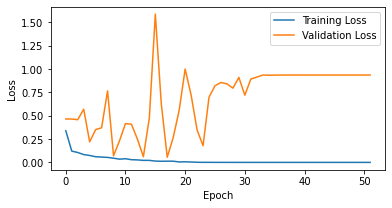

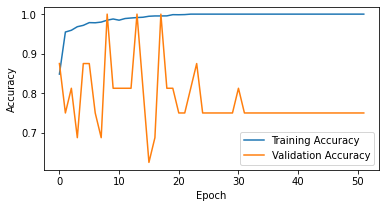

In [18]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load the training history
loaded_history = np.load('models/cnn_1_history.npy', allow_pickle=True).item()

# Plot the training loss and validation loss
plt.figure(figsize=(6,3))
plt.plot(loaded_history['loss'], label='Training Loss')
plt.plot(loaded_history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training accuracy and validation accuracy
plt.figure(figsize=(6,3))
plt.plot(loaded_history['accuracy'], label='Training Accuracy')
plt.plot(loaded_history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [23]:
results_train = model_cnn_1.evaluate(train_generator)
results_test = model_cnn_1.evaluate(test_generator)

10/10 [==============================] - 9s 868ms/step - loss: 0.6837 - accuracy: 0.6154


In [24]:
results_train

[0.6680111289024353, 0.7315950989723206]

In [25]:
results_test

[0.68365079164505, 0.6153846383094788]

The graph shows that the model is overfitting. This is because the training loss is decreasing while the validation loss is increasing. This means that the model is learning the training data too well and is not generalizing well to new data.

In comparison to our simple MLP model we are now capturing more of the data features but now there is so much noise. 

This can be due to too many layers. We can see after 30 epochs the loss is just flat suggesting a very bad over fit. Lets attempt to reduce model complexity by reducing the number of layers or neurons.

## CNN_2

Lets reduce the complexity by reducing the Conv2D layers from 32 filter to 16 and 8. Lets end the neural network with a single Dense layer of one neuron for binary classification. Lets see if we reduce overfit this way

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
# Define the model
model_cnn_2 = Sequential()

# Add Convolutional Layer to look more for local features
model_cnn_2.add(Conv2D(16, kernel_size=(2,2), activation='relu', input_shape=(128, 128, 3)))

# Add Pooling Layer
model_cnn_2.add(MaxPooling2D((2, 2)))

# Add Convolutional Layer to look more for global features
model_cnn_2.add(Conv2D(8, (4, 4), activation='relu'))

# Add Second Pooling Layer
model_cnn_2.add(MaxPooling2D((2, 2)))

# Add a Flatten Layer to prepare data for fully connected layers
model_cnn_2.add(Flatten())

# Add Dense layer with relu
model_cnn_2.add(Dense(1, activation='sigmoid'))

# Compile the model
model_cnn_2.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

print(model_cnn_2.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 127, 127, 16)      208       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 63, 63, 16)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 60, 60, 8)         2056      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 30, 30, 8)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 7200)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 7201      
Total params: 9,465
Trainable params: 9,465
Non-trainable params: 0
____________________________________________________

In [21]:
cnn_2 = train_model_and_get_epoch_data(model_cnn_2, train_generator, val_generator, total_epochs=30, save_history_path="cnn_2_history.npy")
print(cnn_2)

Epoch 1/30
82/82 [==============================] - 91s 1s/step - loss: 0.3702 - accuracy: 0.8311 - val_loss: 0.6765 - val_accuracy: 0.6250
Epoch 2/30
82/82 [==============================] - 41s 505ms/step - loss: 0.1387 - accuracy: 0.9511 - val_loss: 0.5521 - val_accuracy: 0.7500
Epoch 3/30
82/82 [==============================] - 41s 500ms/step - loss: 0.1051 - accuracy: 0.9620 - val_loss: 0.5828 - val_accuracy: 0.6875
Epoch 4/30
82/82 [==============================] - 41s 495ms/step - loss: 0.0897 - accuracy: 0.9664 - val_loss: 0.2122 - val_accuracy: 0.9375
Epoch 5/30
82/82 [==============================] - 42s 510ms/step - loss: 0.0861 - accuracy: 0.9709 - val_loss: 0.7844 - val_accuracy: 0.6875
Epoch 6/30
82/82 [==============================] - 40s 491ms/step - loss: 0.0764 - accuracy: 0.9712 - val_loss: 0.3244 - val_accuracy: 0.8750
Epoch 7/30
82/82 [==============================] - 41s 501ms/step - loss: 0.0670 - accuracy: 0.9735 - val_loss: 0.2522 - val_accuracy: 0.9375
Ep

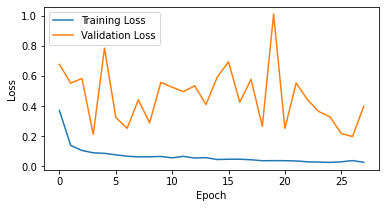

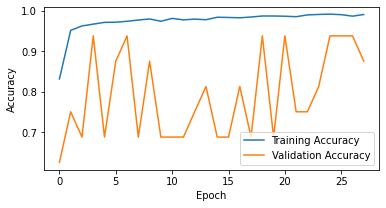

In [22]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load the training history
loaded_history = np.load('models/cnn_2_history.npy', allow_pickle=True).item()

# Plot the training loss and validation loss
plt.figure(figsize=(6,3))
plt.plot(loaded_history['loss'], label='Training Loss')
plt.plot(loaded_history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training accuracy and validation accuracy
plt.figure(figsize=(6,3))
plt.plot(loaded_history['accuracy'], label='Training Accuracy')
plt.plot(loaded_history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [26]:
results_train = model_cnn_2.evaluate(train_generator)
results_test = model_cnn_2.evaluate(test_generator)

10/10 [==============================] - 3s 346ms/step - loss: 1.4046 - accuracy: 0.7420


In [27]:
results_train

[0.018508831039071083, 0.9952070713043213]

In [28]:
results_test

[1.4045616388320923, 0.7419871687889099]

The graph shows that the model is overfitting. This is because the training loss is consistently lower than the validation loss, and the validation loss is increasing while the training loss is decreasing. This suggests that the model is not generalizing well to new data.

Eventhough we have a cnn network it doesnt do that much better than the basic mlp network. We might have to consider data augmentation and regularization or dropouts for the cnn

# CNN 3